# AIComprehendChats

**Contexto empresarial**. Diariamente miles de clientes se comunican con el chatbot de la empresa para recibir atenci√≥n post venta.
El contenido de cada sesi√≥n de chat se guarda en distintas tablas de BigQuery a las cuales accedemos para hacer an√°lisis de los datos.
AL finalizar la atenci√≥n, el bot invita al usuario a responder una encuesta sobre la atenci√≥n recibida.
Estas calificaciones nos permiten tomar acciones posteriores para mejorar los procesos m√°s dolorosos para el cliente.
Este proyecto propone cuantificar la satisfacci√≥n del cliente derivada de las interacciones no calificadas para entender mejor los motivos donde el cliente no lleg√≥ al resultado esperado y as√≠ poder tomar decisiones comerciales, incluso en tiempo real para gesti√≥n de crisis.

**Problema empresarial.** el proposito de este proyecto consiste en crear modelos que identifiquen el sentimiento (positivo o negativo) de cada una de estas interacciones no calificadas.

**Desaf√≠os.** Leer y analizar los datos del texto de entrada y las variables de respuesta correspondientes (calificaciones).
Realizar un preprocesamiento b√°sico para preparar los datos para el modelado.
Aplicar diversas t√©cnicas de NLP para caracterizar el texto de las rese√±as.
Construir modelos de aprendizaje autom√°tico para clasificar el texto seg√∫n su opini√≥n, ya sea positiva o negativa (1 o 0).

## Importaci√≥n de librer√≠as

In [ ]:
!pip install numpy==1.25.2 # intsalacion de una versi√≥n especifica de Numpy para resolver a posteriori problemas de compatibilidad con librer√≠a gensim

In [ ]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import histplot

# NLP packages
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Carga de datos

Trabajaremos con un archivo .csv que contiene el texto de las conversaciones de clientes que posteriormente han calificado la atenci√≥n recibida.

Para garantizar la privacidad y seguridad de los datos sensibles de los clientes durante el an√°lisis de chats, se implement√≥ una estrategia de anonimizaci√≥n basada en el enmascaramiento mediante expresiones regulares en consultas SQL. Este proceso involucr√≥ la identificaci√≥n y sustituci√≥n de patrones de informaci√≥n sensible, como n√∫meros de tel√©fono, correos electr√≥nicos y nombres de empresas, por marcadores de anonimizaci√≥n ("***") utilizando la funci√≥n `REGEXP_REPLACE`. La anonimizaci√≥n, realizada dentro de una subconsulta `WITH` antes de operaciones de uni√≥n y agregaci√≥n, busca cumplir con regulaciones como el **Reglamento General de Protecci√≥n de Datos**, fortalecer la confianza del cliente, prevenir riesgos y actuar de manera √©tica.

De esta forma, los datos incluyen los siguientes atributos:
* **session_id:** identificador de la conversaci√≥n existente dentro del chat.
* *session_creation_date:* marca tempostal de inicio de la sesi√≥n.
* **realizarEncuesta:** variable que representa si el cliente accede a responder la encuesta.
* **csat:** nota sobre la atenci√≥n recibida. Valor 1 representa el menor grado de satisfacci√≥n y 5 el mayor grado de satisfacci√≥n.
* **solved:** respuesta booleana sobre la la reoluci√≥n satisfactoria del motivo del contacto.
* **nps:** nota sobre la satisfacci√≥n general sobre el servicio contratado. Valor 1 representa el menor grado de satisfacci√≥n y 10 el mayor grado de satisfacci√≥n.
* **review:** comentarioque hace el usuario sobre su experiencia con el chat de atenci√≥n.
* **sentiment_label:** a partir de las notas de atenci√≥n, se agrupan como positivas las de valor 4 y 5 y negativas las de valor 1 y 2.(m√°s adelante refinaremos esta variable para usarla como target).
* **user_message:** contenido de los mensajes enviados por el usuario.
* **bot_message:** contenido de los mensajes enviados por chatbot.
* **operator_message:** contenido de los mensajes enviados por asistente humano.

In [ ]:
%%time
df = pd.read_csv("https://media.githubusercontent.com/media/vierbo/Data-Science/refs/heads/main/AIComprehendChats/bm_messages_aggregated_AND_encuesta.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269306 entries, 0 to 269305
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   session_id             269306 non-null  object 
 1   session_creation_date  269306 non-null  object 
 2   realizarEncuesta       216834 non-null  object 
 3   csat                   269306 non-null  int64  
 4   solved                 269268 non-null  object 
 5   nps                    251160 non-null  float64
 6   review                 216744 non-null  object 
 7   sentiment_label        269306 non-null  int64  
 8   user_message           250935 non-null  object 
 9   bot_message            262974 non-null  object 
 10  operator_message       224528 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 22.6+ MB
CPU times: user 17.2 s, sys: 4.63 s, total: 21.8 s
Wall time: 57 s


## Data Wrangling

Antes de comenzar a analizar los datos, se procesar√°n para eliminar filas y columnas que no sean relevantes, manipulaci√≥n de registros nulos, ajustar el formato de los datos y crear nuevos campos necesarios para el modelo.

In [ ]:
# Imputar NaN en NPS con 1 si CSAT es "detractor", con 9 si CSAT "promoter", o 7 si es "neutral"
df['nps'] = df['nps'].fillna(
    df.apply(lambda row: 1 if pd.isna(row['nps']) and row['csat'] < 3 else row['nps'], axis=1)
)
df['nps'] = df['nps'].fillna(
    df.apply(lambda row: 9 if pd.isna(row['nps']) and row['csat'] > 3 else row['nps'], axis=1)
)
df['nps'] = df['nps'].fillna(
    df.apply(lambda row: 7 if pd.isna(row['nps']) and row['csat'] == 3 else row['nps'], axis=1)
)

In [ ]:
# Imputar NaN en solved con False si CSAT es "neutral" o "detractor", con True si CSAT "promoter".
df['solved'] = df['solved'].fillna(
    df.apply(lambda row: False if pd.isna(row['solved']) and row['csat'] <= 3 else row['solved'], axis=1)
)
df['solved'] = df['solved'].fillna(
    df.apply(lambda row: True if pd.isna(row['solved']) and row['csat'] > 3 else row['solved'], axis=1)
)

<ipython-input-5-1578add9890b>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['solved'] = df['solved'].fillna(


In [ ]:
# Ajuste de campos al formato deseado
df['nps'] = pd.to_numeric(df['nps'], errors='coerce').fillna(0).astype(int)
df['review'] = df['review'].astype(str)
df['user_message'] = df['user_message'].astype(str)
df['bot_message'] = df['bot_message'].astype(str)
df['operator_message'] = df['operator_message'].astype(str)
df['session_creation_date'] = pd.to_datetime(df['session_creation_date'],  format="%Y-%m-%d")
df['solved'] = df['solved'].replace({True: 1, False: 0}).fillna(0).astype(int)

<ipython-input-6-d7cf950e7f2e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['solved'] = df['solved'].replace({True: 1, False: 0}).fillna(0).astype(int)


In [ ]:
# Eliminar las los campos irrelevantes
if 'realizarEncuesta' in df.columns:
  df = df.drop('realizarEncuesta', axis=1)
if 'session_id' in df.columns:
  df = df.drop('session_id', axis=1)
if 'sentiment_label' in df.columns:
  df = df.drop('sentiment_label', axis=1)

In [ ]:
# Elimimaci√≥n de registros sin nota de atenci√≥n o contenido en mensajes de usuario o bot.
df = df[(df['csat'].notna()) & (df['user_message'].notna()) & (df['user_message'] != '') &(df['bot_message'].notna())& (df['bot_message'] != '')]
df.reset_index(drop=True, inplace=True)

Analizando el contenido de los mensajes de usuario, encontramos muchas sesiones "vac√≠as" creadas a partir un mensaje de saludo o respuesta sobre la sesi√≥n anterior, pero que luego no contin√∫a. Por esto, vamos a conservar solo las sesiones donde el usuario escribi√≥ al menos tres palabras.

In [ ]:
df['user_message_words']= df["user_message"].apply(lambda x: len(str(x).split(" ")) if not isinstance(x, float) or not pd.isna(x) else 0)
##df.head().sort_values(by='user_message_words')

In [ ]:
# Eliminar filas donde los mensajes del usuario tengan menos de 2 palabras
df = df[df['user_message_words'] > 3]
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215490 entries, 0 to 215489
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   session_creation_date  215490 non-null  datetime64[ns]
 1   csat                   215490 non-null  int64         
 2   solved                 215490 non-null  int64         
 3   nps                    215490 non-null  int64         
 4   review                 215490 non-null  object        
 5   user_message           215490 non-null  object        
 6   bot_message            215490 non-null  object        
 7   operator_message       215490 non-null  object        
 8   user_message_words     215490 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 14.8+ MB


## Exploratory Data Analysis

Hacemos algunos an√°lisis generales de los datos disponibles para entenderlos mejor.

### CSAT

Text(0.5, 1.0, 'Distribuci√≥n de nota de atenci√≥n (CSAT)')

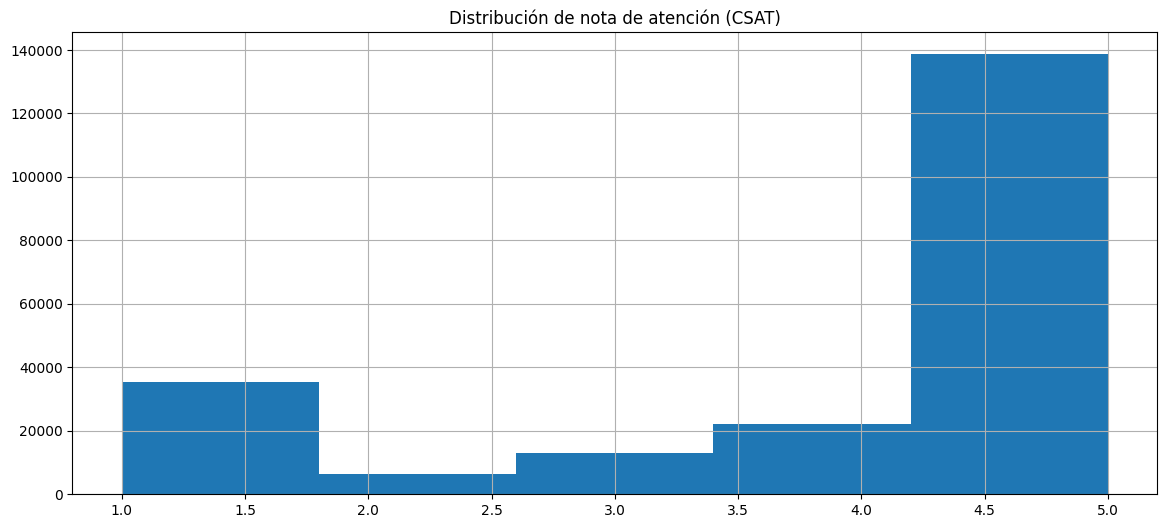

In [ ]:
df['csat'].value_counts().sort_index(ascending=True)
df['csat'].hist(bins=5)
plt.title('Distribuci√≥n de nota de atenci√≥n (CSAT)')

In [ ]:
# Calcula la cantidad de detractores, neutrales y promotores
detractors = df[df['csat'] < 3]['csat'].count()
neutrals = df[df['csat'] == 3]['csat'].count()
promoters = df[df['csat'] > 3]['csat'].count()

# Crea los datos para el gr√°fico circular
labels = ['Detractors', 'Neutral', 'Promoters']
sizes = [detractors, neutrals, promoters]
colors = ['#FF9BFF', '#5B636B', '#85F07F']

# Crea el gr√°fico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribuci√≥n CSAT')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Ajusta la est√©tica de Seaborn (opcional)
sns.set_style("whitegrid")  # o "darkgrid", "white", "dark", "ticks"
sns.set_palette(colors) # Usa los mismos colores de antes

plt.show()


In [ ]:
plt.figure(figsize=(20, 5))
sns.set(style="whitegrid")

# group by the song's popularity and then get the mean energy
x = df.groupby("session_creation_date")["csat"].mean()
axis = sns.lineplot(x=x.index, y=x)

axis.set_ylabel('nota de atenci√≥n')
axis.set_xlabel('fecha')
axis.set_title("evoluci√≥n de CSAT")

Text(0.5, 1.0, 'evoluci√≥n de CSAT')

### NPS

Text(0.5, 1.0, 'Distribuci√≥n de nota de servicio (NPS)')

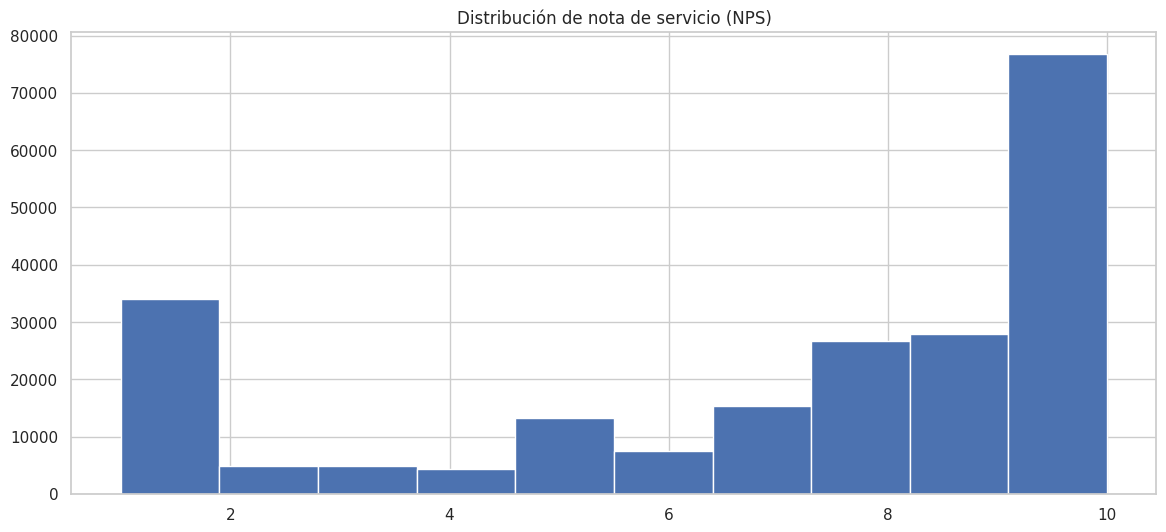

In [ ]:
df['nps'].value_counts().sort_index(ascending=True)
df['nps'].hist(bins=10)
plt.title('Distribuci√≥n de nota de servicio (NPS)')

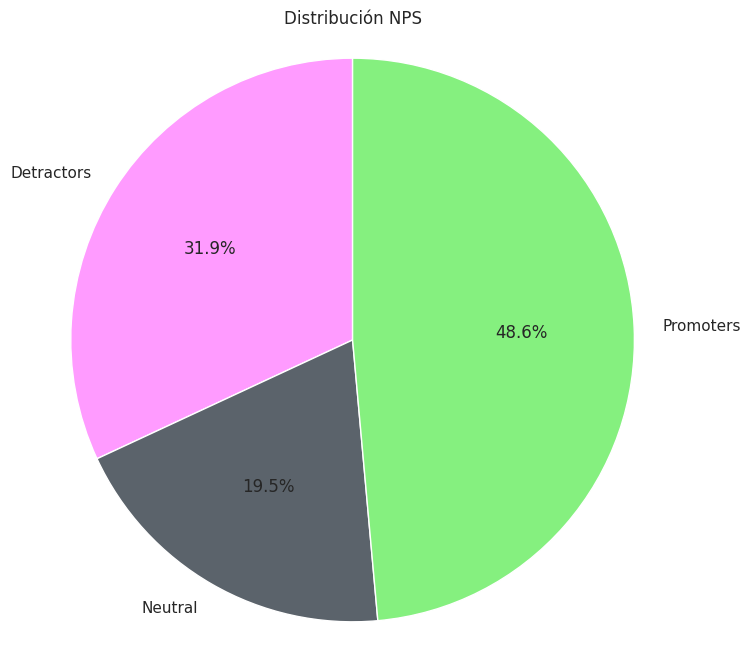

In [ ]:
# Calcula la cantidad de detractores, neutrales y promotores
detractors = df[df['nps'] <= 6]['nps'].count()
neutrals = df[df['nps'].isin([7, 8])]['csat'].count()
promoters = df[df['nps'] >= 9]['csat'].count()

# Crea los datos para el gr√°fico circular
labels = ['Detractors', 'Neutral', 'Promoters']
sizes = [detractors, neutrals, promoters]
colors = ['#FF9BFF', '#5B636B', '#85F07F']

# Crea el gr√°fico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribuci√≥n NPS')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Ajusta la est√©tica de Seaborn (opcional)
sns.set_style("whitegrid")  # o "darkgrid", "white", "dark", "ticks"
sns.set_palette(colors) # Usa los mismos colores de antes
plt.show()

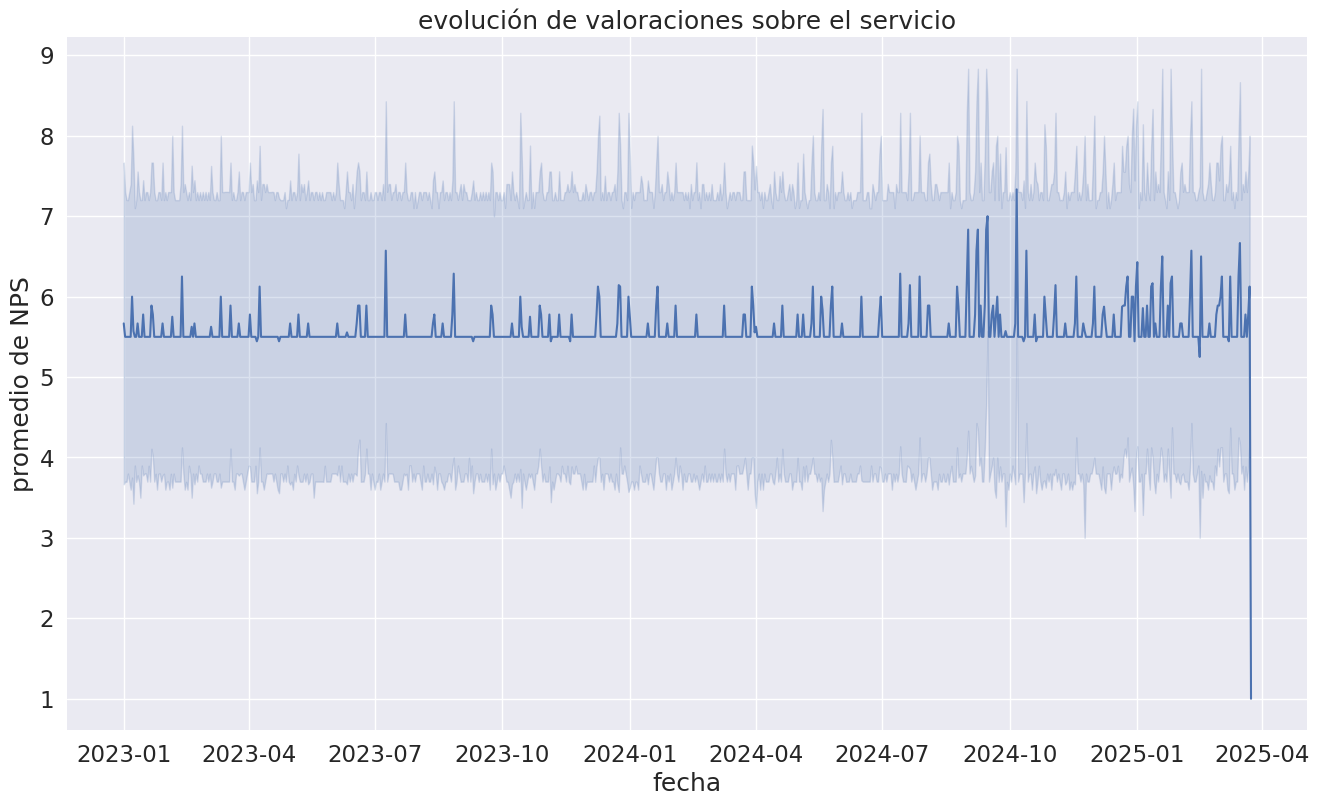

In [ ]:
data = df[['session_creation_date','nps']].drop_duplicates().copy()
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)
sns.lineplot(data,x='session_creation_date',y='nps')
plt.xlabel('fecha')
plt.ylabel('promedio de NPS')
plt.title('evoluci√≥n de valoraciones sobre el servicio')
# Obtener el objeto de los ejes actual
ax = plt.gca()

# Quitar las espinas (bordes) del gr√°fico using the Axes object
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Quitar las marcas de los ejes
plt.tick_params(top=False, bottom=False, left=False, right=False)

### Tama√±o del chat

In [ ]:
#Histograma
words_per_review = df["user_message"].apply(lambda x: len(str(x).split(" ")) if not isinstance(x, float) or not pd.isna(x) else 0)
histplot(words_per_review, kde=True, bins=100,alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Histograma de mensajes de Usuario')
plt.xlabel('largo del chat (en palabras)')
plt.ylabel('cantidad de sesiones')

Text(0, 0.5, 'cantidad de sesiones')

Text(0, 0.5, 'cantidad de sesiones')

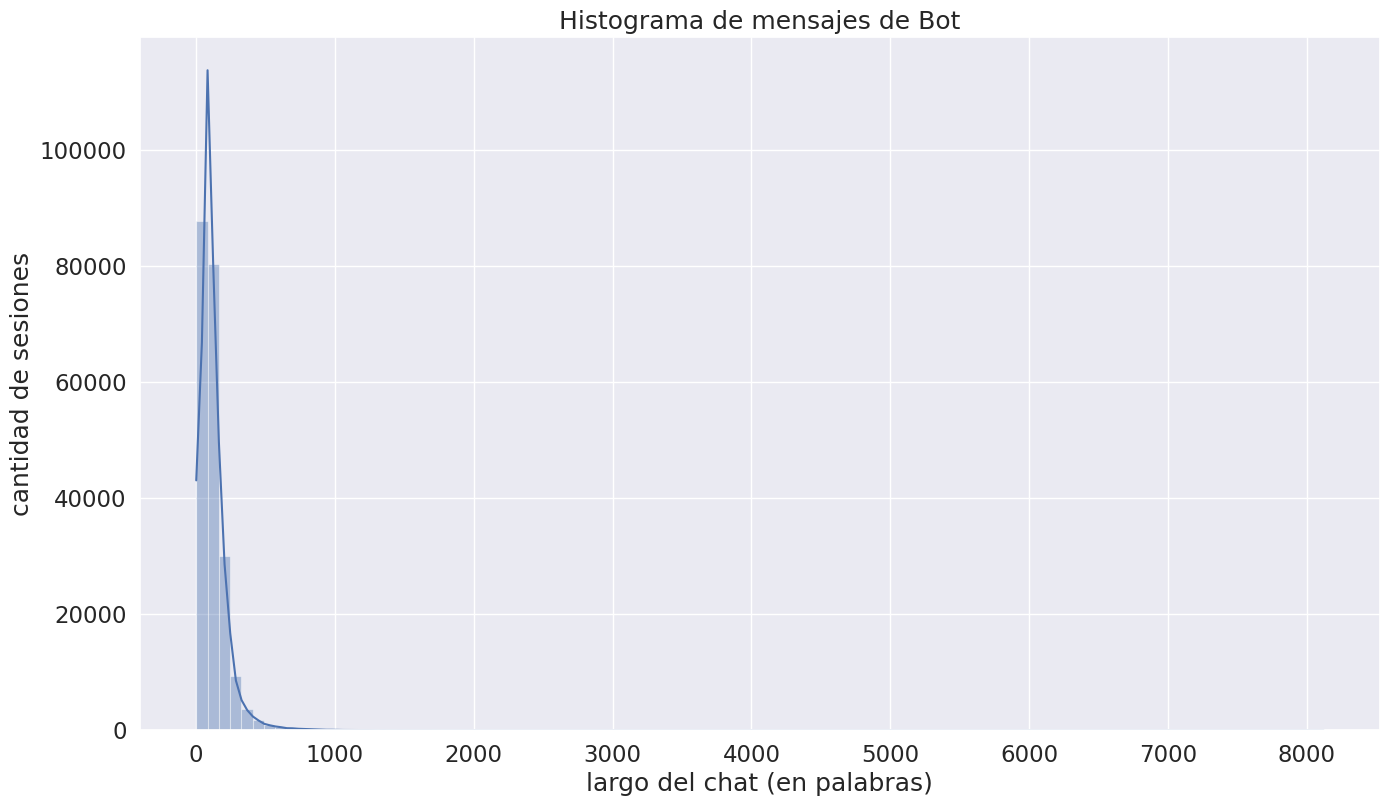

In [ ]:
#Histograma
words_per_review = df["bot_message"].apply(lambda x: len(str(x).split(" ")) if not isinstance(x, float) or not pd.isna(x) else 0)
histplot(words_per_review, kde=True, bins=100,alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Histograma de mensajes de Bot')
plt.xlabel('largo del chat (en palabras)')
plt.ylabel('cantidad de sesiones')

In [ ]:
print('Promedio de palabras:', words_per_review.mean())
print('Sesgo/Asimetr√≠a:', words_per_review.skew())

Promedio de palabras: 120.42787600352685
Sesgo/Asimetr√≠a: 11.823540613474716


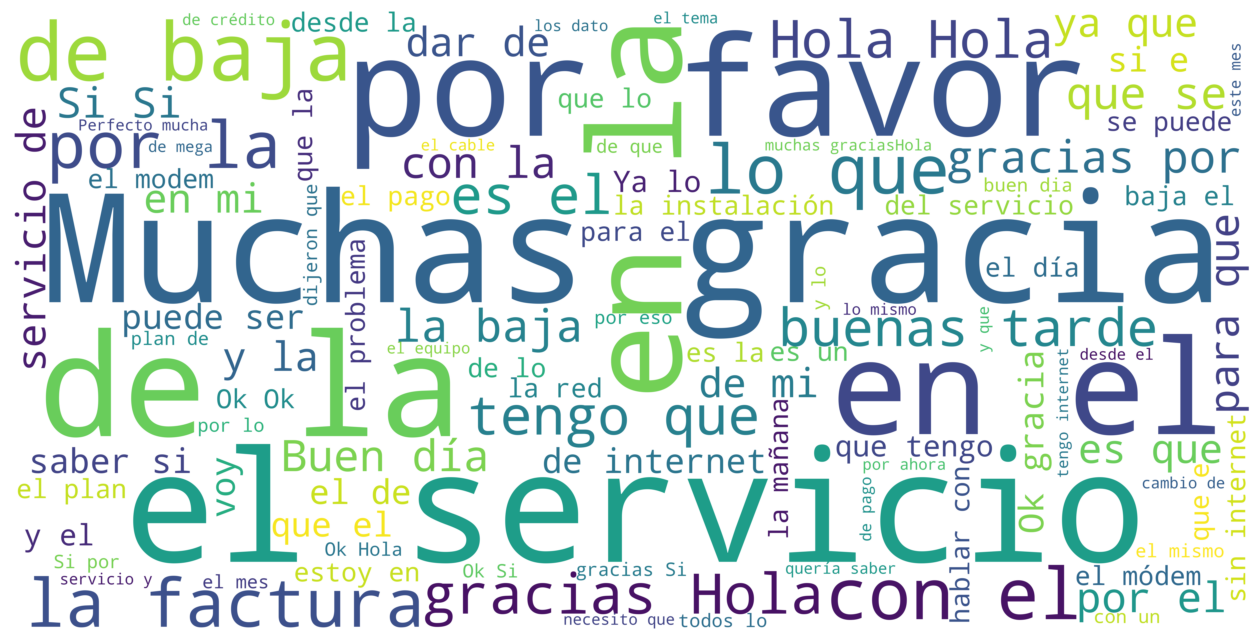

CPU times: user 59.9 s, sys: 3.54 s, total: 1min 3s
Wall time: 1min 3s


In [ ]:
%%time
word_cloud_text = ''.join(df['user_message'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

Como vemos, la gran mayoria se palabras m√°s frecuentes no tienen ning√∫n valor de an√°lisis, es decir, podemos considerarlas como palabras vac√≠as. Por esto, vamos a aplicar algunas t√©cnicas de pre porcesamiento antes de llegar al modelo de NLP.

## Pre-processing

 El preprocesamiento y la normalizaci√≥n del texto son cruciales antes de construir un modelo de NLP adecuado.

### Normalizaci√≥n de calificaciones de atenci√≥n

Para el an√°lisis de sentimiento, convertiremos todas las calificaciones en valores binarios siguiendo la siguiente regla:


*   Las calificaciones de 4 o 5 se asignar√°n a 1 y se relacionar√°n con rese√±as positivas.
*   Las calificaciones de 1 o 2 se asignar√°n a 0 y se relacionar√°n con rese√±as negativas.
*   Las calificaciones de 3 se eliminar√°n, ya que representan rese√±as neutrales.

In [ ]:
# Mapeo de las calificaciones
df['Sentiment_rating'] = np.where(df.csat > 3,1,0)

## Eliminaci√≥n de rese√±as neutrales
df = df[df.csat != 3]
df.reset_index(drop=True, inplace=True)

# Impresi√≥n de los recuentos de cada clase
df['Sentiment_rating'].value_counts()

Sentiment_rating
1    160818
0     41650
Name: count, dtype: int64

In [ ]:
df.Sentiment_rating.value_counts().plot.bar()
plt.show()

### Undersampling

Existe un desequilibrio de clases muy grande de casi 4:1, por lo tanto aplicaremos t√©cnicas de **undersampling**, eliminnando muestras de la clase mayoritaria para igualar el n√∫mero de muestras en todas las clases.

In [ ]:
from sklearn.utils import resample

 # Separar las clases
df_majority = df[df.Sentiment_rating == 1]  # Clase mayoritaria (ejemplo)
df_minority = df[df.Sentiment_rating == 0]  # Clase minoritaria (ejemplo)

 # Submuestrear la clase mayoritaria
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=123) # reproducible results

 # Combinar la clase minoritaria con la clase mayoritaria submuestreada
df = pd.concat([df_majority_downsampled, df_minority])
df.reset_index(drop=True, inplace=True)

 # Verificar el balance
print(df['Sentiment_rating'].value_counts())

Sentiment_rating
1    41650
0    41650
Name: count, dtype: int64


### Eliminar informaci√≥n personal con NER

La limpieza de datos sensibles con **Named Entity Recognition** (NER) es crucial para anonimizar informaci√≥n personal identificable (PII) en textos. Esto permite analizar y utilizar los datos sin comprometer la privacidad de los individuos y cumpliendo con las regulaciones de protecci√≥n de datos.

Realizamos este proceso de anonimizaci√≥n para proteger la privacidad de los usuarios y cumplir con las regulaciones de protecci√≥n de datos. Al eliminar la informaci√≥n personal de los datos de texto, como nombres, ubicaciones y organizaciones, nos aseguramos de que los datos puedan ser utilizados para an√°lisis y modelado de lenguaje natural sin comprometer la confidencialidad de los individuos involucrados. Esto es fundamental para construir sistemas de inteligencia artificial responsables y √©ticos.

In [ ]:
!python -m spacy download es_core_news_sm
import spacy
import re
nlp = spacy.load("es_core_news_sm") # cargar modelo de lenguaje espa√±ol

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.9/12.9 MB 26.5 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Anonimiza la informaci√≥n personal en un texto utilizando NER.
def anonimizar_texto(texto):
    doc = nlp(texto)
    nuevas_palabras = []
    for ent in doc.ents:
        if ent.label_ in ["PER", "ORG", "LOC"]: # Identificar entidades PERSONA, ORGANIZACION, LOCATION
            # Escape special characters in ent.text to treat them literally
            texto = re.sub(re.escape(ent.text), "***", texto) # reemplaza la entidad con "[ANONIMIZADO]"
    return texto

In [ ]:
# Anonimiza una columna de texto en un DataFrame.
def anonimizar_columna(df, columna):
    df[columna + '_anonimizado'] = df[columna].apply(anonimizar_texto)
    return df

In [ ]:
# Ejemplo de uso:
texto_ejemplo = "Juan P√©rez trabaja en Google en Madrid."
texto_anonimizado = anonimizar_texto(texto_ejemplo)
print(texto_anonimizado)

*** trabaja en *** en ***.


In [ ]:
%%time
df = anonimizar_columna(df, 'user_message')

CPU times: user 32min, sys: 3.99 s, total: 32min 4s
Wall time: 32min 18s


In [ ]:
df[['user_message','user_message_anonimizado']].head() # muestra las primeras lineas del texto anonimizado

user_message  \
0  Hola\n***\n***\nBuenos d√≠as, Jorgelina\nEstoy ...   
1  Buenas tardes\n***\n***\nBuenas tardes\nNecesi...   
2  Hola Agustina\nEse es viejo..... Ped√≠ que lo c...   
3  Hola\nM√≥nica Loru\n***\nAv corrientes ***\nNin...   
4  Hola, por algun motivo internet se desconecta ...   

                            user_message_anonimizado  
0  ***\n***\n***\n*** d√≠as, *** experimentando co...  
1  Buenas tardes\n***\n***\nBuenas tardes\nNecesi...  
2  *** es viejo..... *** que lo cambien porque no...  
3  ***\n***\nAv corrientes ***\nNinguno\nSi\nM√≥ni...  
4  ***, por algun motivo internet se desconecta d...

In [ ]:
df['user_message'] = df['user_message_anonimizado']

### Convertir palabras a min√∫sculas

Empecemos por convertir todas las palabras a un formato coherente de may√∫sculas y min√∫sculas:

In [ ]:
# Lista de columnas a convertir a min√∫sculas
msg_cols = ['user_message', 'bot_message', 'operator_message']

# Iterar sobre las columnas y crear nuevas columnas en min√∫sculas
for columna in msg_cols:
    nueva_columna = columna + '_new'
    df[nueva_columna] = df[columna].str.lower()

### word tokenization

En la siguiente celda de c√≥digo analizamos el n√∫mero de palabras √∫nicas que se encuentran en las rese√±as antes y despu√©s de aplicar este paso. Este proceso de extracci√≥n de palabras individuales se denomina tokenizaci√≥n de palabras, y puede ejecutarse utilizando la funci√≥n word_tokenize del paquete nltk:

In [ ]:
%%time
# Textos sin convertir a minusculas
token_lists = [word_tokenize(each) for each in df['user_message']]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens √∫nicos ANTES: ",len(set(tokens)))

Cantidad de tokens √∫nicos ANTES:  118144
CPU times: user 52.5 s, sys: 560 ms, total: 53.1 s
Wall time: 1min 4s


In [ ]:
%%time
# Textos convertidos a minusculas
token_lists_lower = [word_tokenize(each) for each in df['user_message_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Cantidad de tokens √∫nicos AHORA: ",len(set(tokens_lower)))

Cantidad de tokens √∫nicos AHORA:  85020
CPU times: user 55.2 s, sys: 769 ms, total: 55.9 s
Wall time: 56.2 s


In [ ]:
(len(set(tokens))-len(set(tokens_lower))) / len(set(tokens))

0.19008159534127844

El n√∫mero de tokens se ha reducido en un 19% s√≥lo por la normalizaci√≥n del corpus.

### Eliminar caracteres especiales

Para simplificar, procederemos eliminando todos los caracteres especiales; sin embargo, conviene tener en cuenta que esto deber√° revisarse seg√∫n los resultados que obtengamos posteriormente. A continuaci√≥n, se muestra una lista de todos los caracteres especiales de nuestro conjunto de datos:

In [ ]:
# Seleccionando los caracteres no alfanumericos que no son espacios
special_chars = df['user_message_new'].apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'\uf0b7', 'ü•á', 'üò®', 'üôÑ', 'ü§ë', 'üòÇ', 'üîå', 'üï∫', 'üê∂', '‚õë', 'üò§', 'üíµ', '\u200b', 'üá©', ']', '+', 'üá±', 'ü´§', 'ü•ê', ',', 'üòú', 'üíû', 'üçì', 'üòÉ', '‚Äî', '‚¨á', 'üåß', '‚öñ', 'üßª', '\n', '.', 'üèº', '‚òù', 'üíÉ', 'üòö', 'üç§', 'üéª', 'üëØ', 'üìß', '‚õÑ', '‚óè', 'üì¢', 'ü§î', '‚ôÇ', '\t', '‚ñ∂', 'üíª', 'üì≤', '\u202f', 'Ôºå', 'ü´•', 'üôå', 'ü¶∂', '\u2060', 'üè¥', '¬ª', 'üíú', 'üò∂', '‚ú®', 'üò°', 'ü´∞', 'üè∏', 'üíº', 'üòê', 'üò¶', '‚åõ', 'ü§¨', 'ü™ú', 'üòñ', 'ü•É', '‚ôÄ', '¬©', '‚úã', 'üßò', 'üëê', 'üò´', 'üïõ', 'üí¥', 'üß®', 'ü¶Å', ')', 'üí≤', 'üíö', 'üòß', 'ÃÅ', 'üíò', 'üò•', 'üáø', '‚îú', '\\', 'üßë', 'üëø', 'üçá', '‚Äë', 'üòé', '‚úì', 'üóí', '‚Äø', '‚îÄ', 'üçπ', 'üòò', 'üëä', '‚åö', 'üçº', 'üçã', 'ü´†', 'üìë', 'ü™Ñ', 'üòº', 'üì±', 'üìû', 'üíÄ', 'üöº', 'ü§å', 'üÜó', 'üòÑ', 'üê∏', 'üìç', 'üòÅ', 'üïµ', '=', '\U0001fa77', '‚ûñ', '$', '}', 'üõé', 'üç≠', 'üí©', 'üåù', 'üë®', '

In [ ]:
# conservamos una copia del texto original para comparaciones posteriores
df_original_lower = df[['user_message_new', 'bot_message_new']].copy()

Eliminemos estos caracteres especiales de los mensajes aplicando una expresi√≥n regular:

In [ ]:
import re

In [ ]:
%%time
df.user_message_new = df.user_message_new.apply(
    lambda x: re.sub('[^a-zA-Z0-9√±√°√©√≠√≥√∫√º√Å√â√ç√ì√ö√ú\s]+', ' ', x)
)
df['user_message_new'] = df['user_message_new'].str.replace('√°', 'a', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√©', 'e', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√≠', 'i', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√≥', 'o', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√∫', 'u', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√º', 'u', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√Å', 'A', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√â', 'E', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√ç', 'I', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√ì', 'O', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√ö', 'U', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('√ú', 'U', regex=True)

CPU times: user 3.6 s, sys: 100 ms, total: 3.7 s
Wall time: 4.58 s


In [ ]:
%%time
df.bot_message_new = df.bot_message_new.apply(
    lambda x: re.sub('[^a-zA-Z0-9√±√°√©√≠√≥√∫√º√Å√â√ç√ì√ö√ú\s]+', ' ', x)
)
df['bot_message_new'] = df['bot_message_new'].str.replace('√°', 'a', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√©', 'e', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√≠', 'i', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√≥', 'o', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√∫', 'u', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√º', 'u', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√Å', 'A', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√â', 'E', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√ç', 'I', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√ì', 'O', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√ö', 'U', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('√ú', 'U', regex=True)

CPU times: user 4.8 s, sys: 222 ms, total: 5.02 s
Wall time: 5.92 s


In [ ]:
df[[ 'user_message','user_message_new','bot_message','bot_message_new']].head()

user_message  \
0  Hola\n***\n***\nBuenos d√≠as, Jorgelina\nEstoy ...   
1  Buenas tardes\n***\n***\nBuenas tardes\nNecesi...   
2  Hola Agustina\nEse es viejo..... Ped√≠ que lo c...   
3  Hola\nM√≥nica Loru\n***\nAv corrientes ***\nNin...   
4  Hola, por algun motivo internet se desconecta ...   

                                    user_message_new  \
0  hola\n \n \nbuenos dias  jorgelina\nestoy expe...   
1  buenas tardes\n \n \nbuenas tardes\nnecesito s...   
2  hola agustina\nese es viejo  pedi que lo cambi...   
3  hola\nmonica loru\n \nav corrientes  \nninguno...   
4  hola  por algun motivo internet se desconecta ...   

                                         bot_message  \
0  ¬°Bienvenido Rodrigo! üëã\nSoy Axeda, soy tu asis...   
1  Para poder ayudarte mejor, por favor respond√© ...   
2  ¬°Hola DARIO  SABOREDO! üëã\nSoy Axeda, soy tu as...   
3  ¬°Bienvenido Cumpliste! üëã\nSoy Axeda, soy tu as...   
4  ¬°Hola .! üëã\nSoy Axeda, soy tu asistente virtua...   

                                     bot_message_new  
0   bienvenido rodrigo   \nsoy axeda  soy tu asis...  
1  para poder ayudarte mejor  por favor responde ...  
2   hola dario  saboredo   \nsoy axeda  soy tu as...  
3   bienvenido cumpliste   \nsoy axeda  soy tu as...  
4   hola    \nsoy axeda  soy tu asistente virtual...

Miremos como se ven algunos de los resultados luego de remover esto

In [ ]:
print("- ANTES -")
print(df_original_lower.user_message_new.values[28])

- ANTES -
hola
***
***
holaa
hace unos dias hice una consulta y me dijeron que me iban a avisar sobre continuar con el descuento del ***%
porque el mes pasado se me termino
bueno, esta bien
y si sigo con ***mb pueden ser mas meses con el beneficio?
okey
si por favor
y tendrian que venir a cambiar el modem?
o no hace falta
porque estoy de vacaciones y no quedo nadie en el departamento
okey
si por favor
okey muchas gracias!!


In [ ]:

print("\n- AHORA -")
print(df['user_message_new'][28])


- AHORA -
hola
 
 
holaa
hace unos dias hice una consulta y me dijeron que me iban a avisar sobre continuar con el descuento del  
porque el mes pasado se me termino
bueno  esta bien
y si sigo con  mb pueden ser mas meses con el beneficio 
okey
si por favor
y tendrian que venir a cambiar el modem 
o no hace falta
porque estoy de vacaciones y no quedo nadie en el departamento
okey
si por favor
okey muchas gracias 


Con la eliminaci√≥n de caracteres especiales, el n√∫mero de tokens √∫nicos ha disminuido a√∫n m√°s (+17,6%):

In [ ]:
%%time
token_lists = [word_tokenize(each) for each in df_original_lower['user_message_new']]
backup_tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens √∫nicos ANTES: ",len(set(backup_tokens)))

Cantidad de tokens √∫nicos ANTES:  95687
CPU times: user 45.7 s, sys: 411 ms, total: 46.1 s
Wall time: 46.3 s


In [ ]:
%%time
token_lists = [word_tokenize(each) for each in df['user_message_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens √∫nicos AHORA: ",len(set(tokens)))

Cantidad de tokens √∫nicos AHORA:  78842
CPU times: user 30.9 s, sys: 525 ms, total: 31.5 s
Wall time: 39.8 s


In [ ]:
(len(set(backup_tokens))-len(set(tokens))) / len(set(backup_tokens))

0.17604272262689813

### stopwords y palabras de alta/baja frecuencia

Las palabras vac√≠as son muy frecuentes y no aportan nada al contexto. Por lo tanto, tiene sentido eliminarlas.

In [ ]:
import nltk
from nltk.corpus import stopwords
# Descarga del recurso 'stopwords'
nltk.download('stopwords')

print('Lenguajes disponibles para NLTK v.', nltk.__version__,':')
print(stopwords.fileids())

Lenguajes disponibles para NLTK v. 3.9.1 :
['albanian', 'arabic', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'tamil', 'turkish']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
noise_words = []
esp_stop_words = stopwords.words('spanish')
# esp_stop_words

In [ ]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
print('Top #10 de palabras m√°s frecuentes:')
top_1_percentile[:10]

Top #10 de palabras m√°s frecuentes:


[('que', 232364),
 ('de', 230727),
 ('el', 215108),
 ('no', 209171),
 ('la', 176488),
 ('me', 172338),
 ('y', 164425),
 ('a', 134365),
 ('si', 117992),
 ('en', 102466)]

In [ ]:
pd.DataFrame(top_1_percentile[:40], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

In [ ]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
print('Palabras menos frecuentes: ')
bottom_1_percentile[:40]

Palabras menos frecuentes: 


[('redpsi', 1),
 ('calilegya', 1),
 ('llamenmen', 1),
 ('adaipro', 1),
 ('ekovinilosgmail', 1),
 ('aumentarem', 1),
 ('enxendido', 1),
 ('serviciosi', 1),
 ('contactactandome', 1),
 ('unes', 1),
 ('disfrazo', 1),
 ('abjo', 1),
 ('ciomo', 1),
 ('lamentablemnente', 1),
 ('solucuion', 1),
 ('bunoe', 1),
 ('holanexcequiel', 1),
 ('pingamelo', 1),
 ('estrimear', 1),
 ('porpio', 1),
 ('estriming', 1),
 ('amigoooooooooooooooooo', 1),
 ('ahite', 1),
 ('sacada', 1),
 ('paraaaa', 1),
 ('segudo', 1),
 ('disgregacion', 1),
 ('gontwstaron', 1),
 ('comprobac', 1),
 ('dectu', 1),
 ('posterguen', 1),
 ('gutiertez', 1),
 ('ntinuar', 1),
 ('nachop', 1),
 ('bjorn', 1),
 ('contestase', 1),
 ('gragiassss', 1),
 ('zoo', 1),
 ('mproblema', 1),
 ('desxde', 1)]

Las stopwords y las palabras de alta/baja frecuencia ahora se han agregado a noise_words, que se eliminar√°n de las revisiones antes de entrenar los modelos de aprendizaje autom√°tico.

Es poco probable que las stopwords sean tan √∫tiles, ya que esperamos que aparezcan con la misma frecuencia en las cr√≠ticas positivas y negativas. Las palabras poco comunes pueden ser m√°s significativas y, en teor√≠a, podr√≠an indicar el sentimiento de la revisi√≥n

In [ ]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [ ]:
%%time
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

df['user_text_nonstop'] = df['user_message_new'].apply(lambda row: stopwords_removal(noise_words, row))
df[['user_message','user_text_nonstop']]

CPU times: user 1min 11s, sys: 334 ms, total: 1min 12s
Wall time: 1min 18s


user_message  \
0      Hola\n***\n***\nBuenos d√≠as, Jorgelina\nEstoy ...   
1      Buenas tardes\n***\n***\nBuenas tardes\nNecesi...   
2      Hola Agustina\nEse es viejo..... Ped√≠ que lo c...   
3      Hola\nM√≥nica Loru\n***\nAv corrientes ***\nNin...   
4      Hola, por algun motivo internet se desconecta ...   
...                                                  ...   
83295  hola\nJimena Gotelli\n***\nbauness *** ***to d...   
83296  hola\nCaceres Leonardo\n***\nDean Funes ***\nh...   
83297  Hola\n***\nNo, es otra cosa\nNecesitar√≠a ya qu...   
83298  Hola\nYadira Quinche\n***\nLaprida ***\nQuedar...   
83299  ***\n***\nAs√≠ es\nYa esta desenchufado\nTe avi...   

                                       user_text_nonstop  
0      [jorgelina, experimentando, lenta, pasando, di...  
1      [suspender, inquilinos, dejarlos, varia, refie...  
2      [viejo, cambien, utilizo, accedi, pide, activa...  
3      [monica, loru, corrientes, monica, camisay, co...  
4      [desconecta, smart, demas, configuracion, rein...  
...                                                  ...  
83295              [jimena, bauness, to, villa, urquiza]  
83296  [caceres, leonardo, dean, funes, leonardo, cac...  
83297  [apague, prendo, sucediendo, release, microsof...  
83298              [yadira, laprida, quedaron, ambiente]  
83299  [desenchufado, vuelva, pidieron, enchufarlo, s...  

[83300 rows x 2 columns]

En este punto, luego de la remoci√≥n de stopwords, vale la pena volver a hacer una limpieza de registros vac√≠os a partir de la apicaci√≥n de este proceso

In [ ]:
# Elimimaci√≥n de registro sin contenido.
df = df[(df['user_text_nonstop'].notna()) & (df['user_text_nonstop'] != '')]
df.reset_index(drop=True, inplace=True)

### Stemming & lemmatization

Ahora estamos listos para la √∫ltima parte de nuestro preprocesamiento: **stemming & lemmatization.**

Las diferentes formas de una palabra suelen comunicar esencialmente el mismo significado. Por ejemplo, probablemente no haya diferencia de intenci√≥n entre buscar "zapato" y "zapatos". La misma palabra tambi√©n puede aparecer en diferentes tiempos verbales; por ejemplo, "correr", "corri√≥" y "corriendo". Estas diferencias sint√°cticas entre las formas de las palabras se denominan flexiones. En general, probablemente queramos tratar las flexiones de forma id√©ntica al extraer caracter√≠sticas del texto.

**Stemming** funciona eliminando el final o el principio de la palabra, teniendo en cuenta una lista de prefijos y sufijos comunes.

La **lematizaci√≥n** considera el an√°lisis morfol√≥gico de las palabras. Por lo tanto, considera la gram√°tica de la palabra e intenta encontrar la ra√≠z en lugar de simplemente llegar a ella mediante m√©todos de fuerza bruta.

In [ ]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
%%time
def stemm_terms(row):
    return [lancaster.stem(term) for term in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]

df['user_text_stemm'] = df['user_text_nonstop'].apply(lambda row: stemm_terms(row))
df['user_text_lemm'] = df['user_text_nonstop'].apply(lambda row: lemmatize_terms(row))
df[['user_text_nonstop','user_text_stemm','user_text_lemm']]

CPU times: user 21.6 s, sys: 297 ms, total: 21.9 s
Wall time: 24 s


user_text_nonstop  \
0      [jorgelina, experimentando, lenta, pasando, di...   
1      [suspender, inquilinos, dejarlos, varia, refie...   
2      [viejo, cambien, utilizo, accedi, pide, activa...   
3      [monica, loru, corrientes, monica, camisay, co...   
4      [desconecta, smart, demas, configuracion, rein...   
...                                                  ...   
83295              [jimena, bauness, to, villa, urquiza]   
83296  [caceres, leonardo, dean, funes, leonardo, cac...   
83297  [apague, prendo, sucediendo, release, microsof...   
83298              [yadira, laprida, quedaron, ambiente]   
83299  [desenchufado, vuelva, pidieron, enchufarlo, s...   

                                         user_text_stemm  \
0      [jorgelin, experimentando, lent, pasando, dif,...   
1      [suspend, inquilino, dejarlo, var, refiero, ha...   
2         [viejo, camby, utilizo, acced, pid, activarlo]   
3      [monic, loru, corry, monic, camisay, corry, de...   
4      [desconect, smart, dema, configurac, reiniciar...   
...                                                  ...   
83295                     [jimen, bau, to, vill, urquiz]   
83296  [cac, leonardo, dean, fun, leonardo, cac, dean...   
83297  [apagu, prendo, sucediendo, releas, microsoft,...   
83298                    [yadir, laprid, quedaron, amby]   
83299  [desenchufado, vuelv, pidieron, enchufarlo, so...   

                                          user_text_lemm  
0      [jorgelina, experimentando, lenta, pasando, di...  
1      [suspender, inquilinos, dejarlos, varia, refie...  
2      [viejo, cambien, utilizo, accedi, pide, activa...  
3      [monica, loru, corrientes, monica, camisay, co...  
4      [desconecta, smart, demas, configuracion, rein...  
...                                                  ...  
83295              [jimena, bauness, to, villa, urquiza]  
83296  [caceres, leonardo, dean, funes, leonardo, cac...  
83297  [apague, prendo, sucediendo, release, microsof...  
83298              [yadira, laprida, quedaron, ambiente]  
83299  [desenchufado, vuelva, pidieron, enchufarlo, s...  

[83300 rows x 3 columns]

Volvamos a ver c√≥mo ha mutado la nube de palabras en los mensajes de usuario despu√©s de estos procesos.

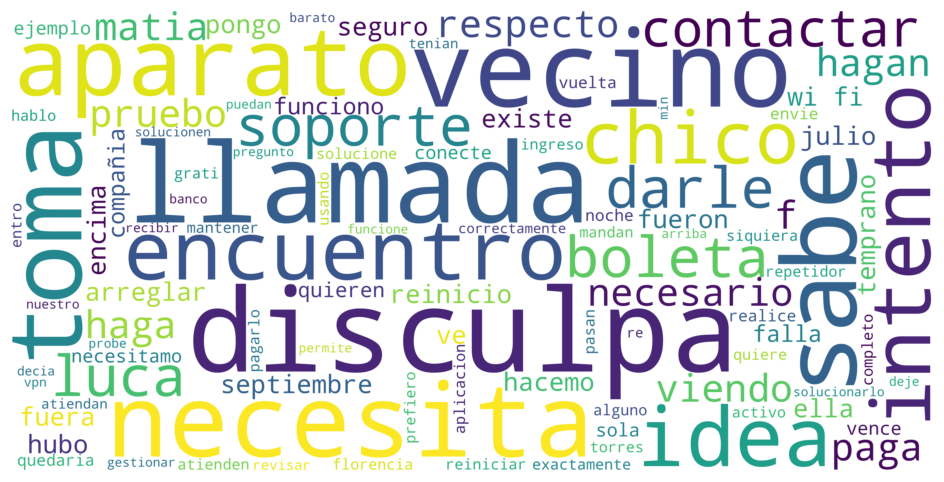

CPU times: user 13.1 s, sys: 1.08 s, total: 14.2 s
Wall time: 16 s


In [ ]:
%%time
#Nube de palabras de textos lematizados + NER:
word_cloud_text = ' '.join([' '.join(review) for review in df['user_text_lemm']])
# Primero, une las palabras dentro de cada rese√±a en una cadena usando ' '.join(review).
# Despu√©s une todas las rese√±as en una sola cadena usando ' '.join(...).

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

# Machine learning model


In [ ]:
# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Bag-of-words

El procedimiento de **bolsa de palabras** se enmarca en una categor√≠a m√°s amplia de t√©cnicas conocidas como representaciones basadas en conteo. Estas t√©cnicas permiten analizar documentos indicando la frecuencia con la que aparecen ciertos tipos de estructuras.

Comencemos con los 1-gramas (palabras). El tipo de informaci√≥n m√°s simple ser√≠a si una palabra en particular aparece en documentos espec√≠ficos. Esto genera matrices de coocurrencia de palabra-documento, donde la entrada de la matriz de palabra-documento se establece en 1 si la palabra
aparece en el documento
, y en 0 en caso contrario.

Creemos una matriz de coocurrencia de palabra-documento para nuestro conjunto de revisiones utilizando la clase CountVectorizer, que considera autom√°ticamente ciertos pasos de preprocesamiento, como la eliminaci√≥n de palabras vac√≠as, la lematizaci√≥n, la creaci√≥n de n-gramas y la tokenizaci√≥n de palabras.

Usemos esto para crear una bolsa de palabras a partir de los mensajes, excluyendo las palabras irrelevantes que identificamos anteriormente:

In [ ]:
# El siguiente c√≥digo crea una matriz de de las palabra en el dataframe.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
# Join the lemmatized tokens back into a single string for each document
df['user_text_lemm_str'] = df['user_text_lemm'].apply(' '.join)
X = vec.fit_transform(df['user_text_lemm_str']) # Use the new string column
## X = vec.fit_transform(df['user_text_lemm'])

In [ ]:
# Cree un nuevo DataFrame para la matriz de palabras para evitar sobrescribir el df original
bow_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
bow_df.head()

aa  aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaa  aaaaaaaaa  aaaaaaaaaa  \
0   0    0     0      0       0        0         0          0           0   
1   0    0     0      0       0        0         0          0           0   
2   0    0     0      0       0        0         0          0           0   
3   0    0     0      0       0        0         0          0           0   
4   0    0     0      0       0        0         0          0           0   

   aaaaaaaaaaa  ...  √±roxe  √±si  √±sos  √±ucas  √±uede  √±uego  √±ujo  √±vlbaad  \
0            0  ...      0    0     0      0      0      0     0        0   
1            0  ...      0    0     0      0      0      0     0        0   
2            0  ...      0    0     0      0      0      0     0        0   
3            0  ...      0    0     0      0      0      0     0        0   
4            0  ...      0    0     0      0      0      0     0        0   

   √±wifi  √±√±  
0      0   0  
1      0   0  
2      0   0  
3      0   0  
4      0   0  

[5 rows x 67976 columns]

In [ ]:
### Creando un objeto de Python de la clase CountVectorizer

bow_counts = CountVectorizer(tokenizer=word_tokenize,  # tipo de tokenizaci√≥n
                             stop_words=noise_words,  # lista de stopwords
                             ngram_range=(1, 1))  # cant de n-grams

# Utilice el df original para crear la representaci√≥n de bolsa de palabras
bow_data = bow_counts.fit_transform(df['user_message_new'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 980355 stored elements and shape (83300, 77266)>

Podemos observar que se ha construido una matriz dispersa de 937773 observaciones  en 83300 filas (n√∫mero de filas de la serie `user_message_new`) y 68572 columnas correspondientes a las caracter√≠sticas extra√≠das mediante la representaci√≥n del recuento de 1 gramo de las rese√±as de los usuarios.

Una vez preparada la bolsa de palabras, el conjunto de datos debe dividirse en conjuntos de entrenamiento y de prueba:

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    df['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [ ]:
y_test_bow.value_counts()/y_test_bow.shape[0]

Sentiment_rating
0    0.508643
1    0.491357
Name: count, dtype: float64

Los datos de prueba contienen un 49 % de rese√±as positivas. Por lo tanto, si clasific√°ramos todas las rese√±as como positivas, nuestro modelo alcanzar√≠a una precisi√≥n del 49 %. Por lo tanto, este es el punto de referencia que cualquier modelo que creemos debe superar.

#### Applying logistic regression to Bag-of-Words

Entrenemos el modelo con nuestros datos de entrenamiento y ejecutemos el modelo resultante en nuestros datos de prueba:

In [ ]:

### Training the model
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.6775692013999364


Obtuvimos un rendimiento del 68%. No es malo pero intentaremos mejorarlo.

Modifiquemos el conjunto de caracter√≠sticas del modelo para incluir bigramas, trigramas y 4-gramas:

In [ ]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(df.user_message_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Observe el aumento de caracter√≠sticas con la inclusi√≥n de n-gramas
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 23910860 stored elements and shape (83300, 8950415)>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    df['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [ ]:
%%time
# Defining and training the model
lr_model_all_new = LogisticRegression(max_iter = 200)
# Fitteo
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 score:  0.8204807992507025
CPU times: user 7min 21s, sys: 1min 11s, total: 8min 32s
Wall time: 7min


La puntuaci√≥n F1 ha aumentado en un 15%. Este es un ejemplo de c√≥mo un simple ajuste de hiperpar√°metros y la modificaci√≥n de las caracter√≠sticas de entrada pueden influir en el rendimiento general.
Incluso podemos obtener caracter√≠sticas interpretables a partir de esto, en t√©rminos de qu√© contribuy√≥ m√°s al sentimiento positivo y negativo:

In [ ]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names_out(), # ge tall the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

print("Top #15 caracter√≠sticas m√°s importantes para obtener rese√±as POSITIVAS:")
lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

Top #15 caracter√≠sticas m√°s importantes para obtener rese√±as POSITIVAS:


words   weights
3439140             gracias  1.726117
5079309         mil gracias  1.472698
6056734            perfecto  1.423030
3157098           excelente  1.320629
241923            agradezco  1.257045
5255918            nada mas  1.238856
2829979             es todo  1.212725
1310413            confirmo  1.197841
3401235              genial  1.197831
811182            buenisimo  1.168324
1301786          confirmado  1.102239
7591353              silvia  1.077812
5397286          no gracias  1.060477
5207722          muchisimas  1.053649
5207755  muchisimas gracias  1.032865

In [ ]:
print("Top #15 caracter√≠sticas m√°s importantes para obtener rese√±as NEGATIVAS::")
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

Top #15 caracter√≠sticas m√°s importantes para obtener rese√±as NEGATIVAS::


words   weights
3859641            imposible -0.711520
5433356          no me sirve -0.740770
3467074   gracias ok gracias -0.764156
3820979               humano -0.775124
366332               alguien -0.780317
2920233            esperando -0.782981
6146302               pesimo -0.823379
3775925                horas -0.862234
3453643      gracias gracias -0.879554
1998459             desastre -0.900146
3475207           gracias si -0.934373
5202907  muchas gracias hola -0.993971
1014228                 chau -1.024660
5398087        no gracias no -1.065937
3455245         gracias hola -1.420991

### TF-IDF model

Las **bolsas de palabras** no son la √∫nica forma de caracterizar texto. Otro m√©todo es el de Frecuencia de **T√©rmino-Frecuencia Inversa de Documento (TF-IDF)**. Este eval√∫a la importancia de una palabra para un documento dentro de un amplio conjunto de documentos (es decir, un corpus). La importancia aumenta proporcionalmente seg√∫n el n√∫mero de veces que aparece una palabra en el documento, pero se compensa con su frecuencia en el corpus.

La ponderaci√≥n TF-IDF es el producto de dos t√©rminos. El primero calcula la Frecuencia de T√©rmino (TF) normalizada; es decir, el n√∫mero de veces que aparece una palabra en un documento dividido entre el n√∫mero total de palabras de ese documento. El segundo t√©rmino es la Frecuencia Inversa de Documento (IDF), calculada como el logaritmo del n√∫mero de documentos del corpus dividido entre el n√∫mero de documentos donde aparece el t√©rmino espec√≠fico.

tf-idf.png

Renovaremos nuestro conjunto original de revisiones basadas en TF-IDF y dividiremos las caracter√≠sticas resultantes en conjuntos de prueba y entrenamiento:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creando un objeto de Python de la clase TF-IDF
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # tipo de tokenizaci√≥n
                               stop_words=noise_words, # lista de stopwords
                               ngram_range=(1,1)) # cant de n-grams

# tfidf_data = tfidf_counts.fit_transform(df['user_text_lemm'])
df['user_text_lemm_str'] = df['user_text_lemm'].apply(' '.join)
# Apply fit_transform on this new column
tfidf_data = tfidf_counts.fit_transform(df['user_text_lemm_str'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
tfidf_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 974350 stored elements and shape (83300, 76561)>

In [ ]:
%%time
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            df['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

CPU times: user 15.7 ms, sys: 2.07 ms, total: 17.8 ms
Wall time: 17.3 ms


#### Applying logistic regression to TF-IDF features

Apliquemos la regresi√≥n log√≠stica a las caracter√≠sticas creadas a partir de TF-IDF:

In [ ]:
%%time
### Instanciar modelo
lr_model_tf_idf = LogisticRegression()

## Entrenar modelo
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Predecir resultados
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluar modelo
print("F1 score: ",f1_score(y_test_tfidf, test_pred_lr_all))

F1 score:  0.6992139523458609
CPU times: user 674 ms, sys: 357 ms, total: 1.03 s
Wall time: 580 ms


Aqu√≠ hemos disminuido ligeramente nuestro valor de puntuaci√≥n F1 con TF-IDF en comparaci√≥n con el enfoque de bolsa de palabras.

### Word embeddings model

El √∫ltimo tipo de caracterizaci√≥n que abordaremos son las **word embeddings ** (incrustaciones de palabras). Se trata de un tipo de representaci√≥n de palabras que permite que palabras con significados similares tengan una representaci√≥n similar. Este enfoque para representar palabras y documentos puede considerarse uno de los avances clave del aprendizaje profundo en la resoluci√≥n de problemas complejos de procesamiento del lenguaje natural. Permite capturar el contexto de una palabra en un documento, su similitud sem√°ntica y sint√°ctica, y su relaci√≥n con otras palabras. Las incrustaciones de palabras son, de hecho, un tipo de t√©cnicas en las que las palabras individuales se representan como vectores de valor real en un espacio vectorial predefinido. Esta ser√≠a una representaci√≥n gr√°fica:

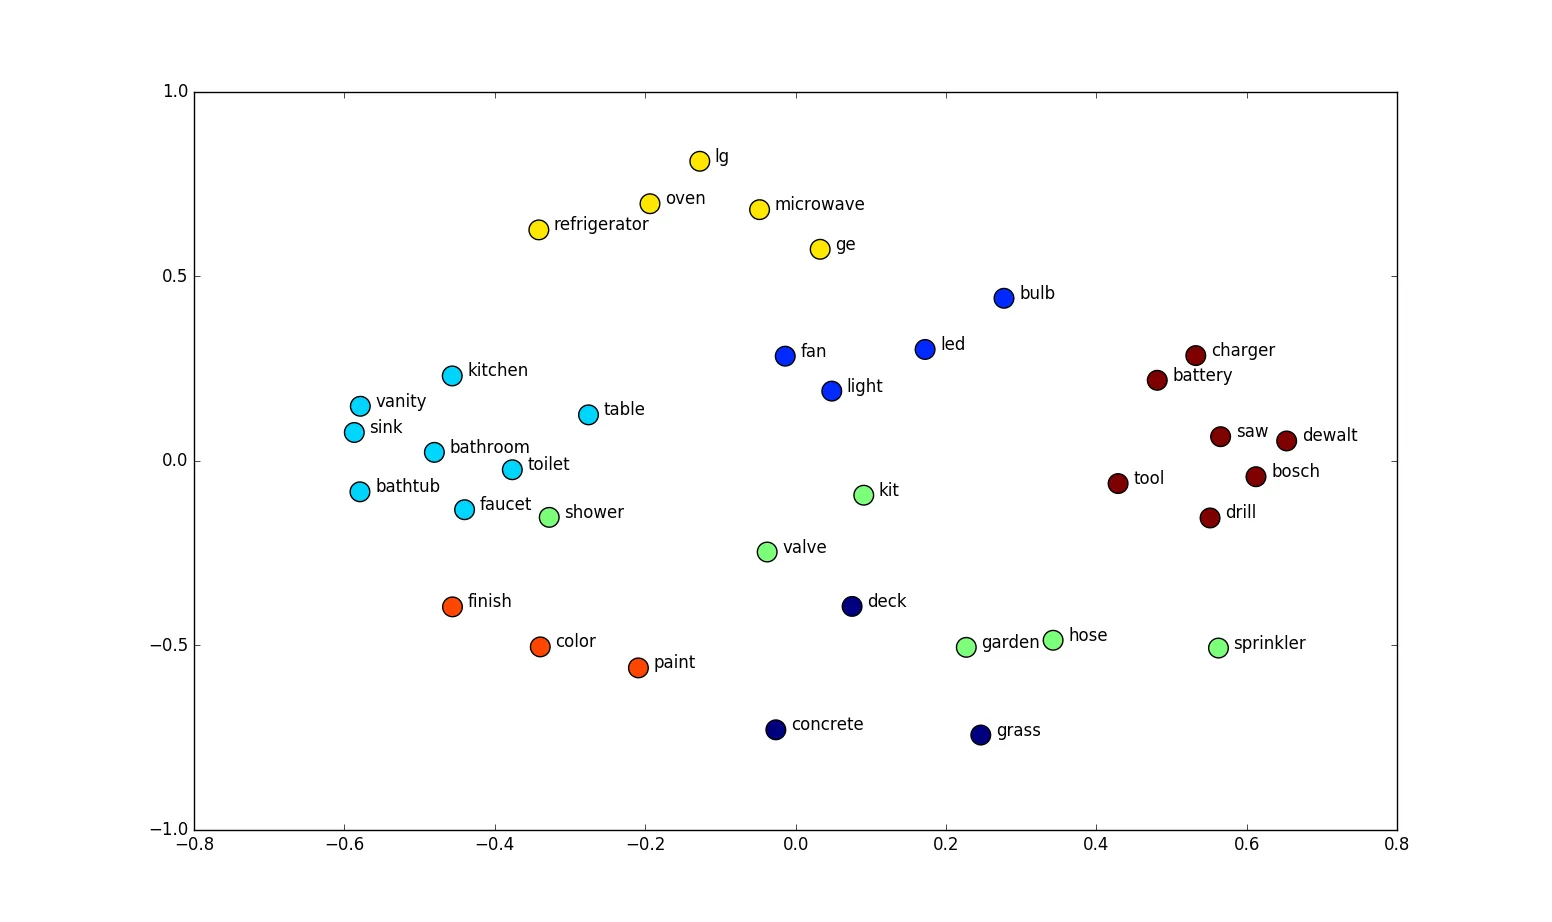

En esta imagen, cada palabra se ha representado en dos dimensiones para simplificar. Se puede observar claramente que las palabras con contexto similar est√°n agrupadas: ba√±o, cocina y ba√±era se agrupan juntas, mientras que microondas, refrigerador y horno forman otro grupo, etc.

Existen diferentes m√©todos para aprender incrustaciones de palabras, como Word2Vec, GloVe, FastText, incrustaci√≥n espectral y UMAP, entre otros:


*   **Word2Vec**: utiliza una Red Neuronal superficial.
*   **GloVe**: es un algoritmo de aprendizaje no supervisado para obtener representaciones vectoriales de palabras. El entrenamiento se realiza con estad√≠sticas globales agregadas de coocurrencia palabra-palabra de un corpus, y las representaciones resultantes muestran interesantes subestructuras lineales del espacio vectorial de palabras.
*   **FastText**: es una biblioteca para el aprendizaje de incrustaciones de palabras y la clasificaci√≥n de textos creada por el laboratorio de investigaci√≥n de IA de Facebook.
*   **Spectral embedding**: es una t√©cnica de reducci√≥n de dimensionalidad que forma una matriz de afinidad aplicando una descomposici√≥n espectral.
*   **UMAP**: la Aproximaci√≥n y Proyecci√≥n de Variedad Uniforme es una t√©cnica de reducci√≥n de dimensionalidad utilizada para procedimientos generales de reducci√≥n de dimensionalidad no lineal.

#### ¬øPor qu√© usar incrustaciones de palabras en lugar de bolsas de palabras y TF-IDF?


Cada palabra se representa mediante un vector de valor real, que generalmente tiene decenas o cientos de dimensiones. Esto contrasta con los miles o millones de dimensiones que requieren las representaciones de palabras dispersas. Por lo tanto, las incrustaciones de palabras pueden reducir dr√°sticamente el n√∫mero de dimensiones necesarias para representar un documento de texto:

In [ ]:
!pip install --upgrade gensim
import gensim

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26.7/26.7 MB 26.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38.6/38.6 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import os

### Loading a pre-trained glove word embedding that is trained on twitter dataset
### This word embedding is 200 dimensional in lenght (200 features per term)
### Source: https://nlp.stanford.edu/projects/glove/
file_path = os.path.join(os.getcwd(), 'glove.twitter.27B.50d.txt')

# Load the model using gensim's KeyedVectors.load_word2vec_format
# with no_header=True to skip the first line if it's not in the expected format
model = gensim.models.KeyedVectors.load_word2vec_format(
    file_path, binary=False, no_header=True
)

Para hallar el vector de una rese√±a completa, obtenemos el vector de cada palabra de la rese√±a por separado y calculamos un promedio simple.

Calculemos el vector de cada rese√±a del conjunto de datos:

In [ ]:
# List for adding each average representation per observation
review_embeddings = []

## Review_average
Review_average = np.zeros(model.vector_size)

# For each review in the review's dataset
for each_review in df['user_text_lemm']:  # each_review is now a list of tokens

    count_val = 0

    # Iterate directly over tokens in each_review
    for each_word in each_review:  # No need for word_tokenize
        if each_word.lower() in model:
            Review_average += model[each_word.lower()]
            count_val += 1

    # Check if count_val is greater than 0 to avoid ZeroDivisionError
    if count_val > 0:
        review_embeddings.append(list(Review_average / count_val))
    else:
        # Handle the case where count_val is 0 (e.g., append a zero vector)
        review_embeddings.append(list(np.zeros(model.vector_size)))

Convertimos la lista de representaciones vectoriales para cada revisi√≥n en un DataFrame y la dividimos en conjuntos de entrenamiento y prueba:

In [ ]:
# Convertir dataframe en objeto
embedding_data = pd.DataFrame(review_embeddings)

# Filling null values
# Los valores nulos son los que el modelo preentrenado de Twitter no considera (algunos de ellos)
embedding_data = embedding_data.fillna(0)
embedding_data

0             1             2             3             4   \
0         -0.028204      0.246429     -0.217723      0.378920     -0.017784   
1         -0.670459      3.118116     -2.564590      4.285620     -0.107512   
2         -1.641849      7.740674     -6.693398     10.944787     -0.240216   
3         -1.487294      5.988696     -4.611615      7.606077     -0.179258   
4         -1.669943      5.286517     -4.499462      6.933848     -0.011733   
...             ...           ...           ...           ...           ...   
83295 -13156.547520  87458.229752 -35513.486615  49661.818444  25809.376750   
83296  -5262.816638  34983.247420 -14205.010498  19864.500285  10323.362925   
83297  -2192.898822  14576.521597  -5918.887964   8277.244993   4301.521662   
83298 -13157.478857  87459.505170 -35513.142386  49663.287224  25809.250616   
83299  -1644.627131  10932.571238  -4439.405631   6208.212307   3226.081872   

                 5             6             7            8              9   \
0          0.191928     -0.155912     -0.197816    -0.111484      -0.611275   
1          1.882318     -1.988789     -1.974564    -0.903523      -6.947047   
2          4.242430     -4.759590     -4.530727    -2.115979     -17.472270   
3          2.822463     -3.649850     -3.307221    -1.557554     -13.138241   
4          2.677730     -3.429149     -3.044028    -1.615963     -11.708093   
...             ...           ...           ...          ...            ...   
83295 -28146.525824 -63293.490147 -17493.337088  3642.997771 -156837.716054   
83296 -11259.355374 -25317.665424  -6997.127043  1456.666053  -62735.538926   
83297  -4691.261213 -10549.215365  -2915.598339   607.166215  -26140.467637   
83298 -28147.619954 -63295.820769 -17493.949203  3642.824457 -156843.685551   
83299  -3518.535599  -7912.144664  -2187.051815   455.328809  -19606.097614   

       ...            40            41            42           43  \
0      ...     -0.180155      0.434801      0.186205    -0.007468   
1      ...     -1.576170      4.720461      2.211184    -0.310999   
2      ...     -3.637669     11.488851      5.556509    -0.811021   
3      ...     -2.649020      8.286570      4.353418    -0.609988   
4      ...     -2.540652      7.847262      3.941739    -0.460988   
...    ...           ...           ...           ...          ...   
83295  ... -69623.328773  47851.965720  53645.481121  6319.665450   
83296  ... -27849.758046  19140.487556  21458.531012  2528.203619   
83297  ... -11604.414953   7975.500320   8941.188482  1053.414402   
83298  ... -69626.303166  47853.289282  53647.252703  6320.434834   
83299  ...  -8703.442039   5981.947983   6706.062818   789.853639   

                44           45            46            47            48  \
0         0.057293     0.167085      0.173903      0.409650     -0.367178   
1         0.877764     2.084893      2.243057      4.588588     -3.937008   
2         2.682659     5.002656      5.864445     11.318395     -9.993417   
3         1.317355     3.904848      4.334702      8.360591     -7.399284   
4         1.117446     3.250307      4.033725      8.008255     -7.111576   
...            ...          ...           ...           ...           ...   
83295  8928.473619  6667.978082  37859.645803  98645.211914 -51043.465767   
83296  3571.485235  2667.231920  15143.613966  39458.376959 -20417.354953   
83297  1488.173286  1111.648165   6309.848659  16441.391274  -8507.716747   
83298  8928.842822  6669.854825  37859.372974  98648.674398 -51046.369870   
83299  1116.179752   833.861044   4732.465703  12331.357472  -6380.861178   

                 49  
0         -0.240655  
1         -2.924256  
2         -7.378227  
3         -5.409431  
4         -5.219228  
...             ...  
83295 -93962.370909  
83296 -37586.001346  
83297 -15661.090208  
83298 -93966.935810  
83299 -11746.217856  

[83300 rows x 50 columns]

#### Applying logistic regression to TF-IDF

In [ ]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(embedding_data,
                                                                            df['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

Apliquemos ahora la regresi√≥n log√≠stica a nuestra representaci√≥n de word-embeddings:

In [ ]:
lr_model_all.fit(X_train_embed, y_train_embed)
test_pred_lr_all = lr_model_all.predict(X_test_embed)

print("F1 score: ",f1_score(y_test_embed, test_pred_lr_all))

F1 score:  0.9813973744789398


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Deep Learning


Construimos una Red Neuronal Recurrente (RNN) con el fin de comparar el √©xito de los algoritmos anteriores con uno m√°s complejo y analizaremos resultados.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
%%time
# 1. Create TF-IDF features
vectorizer = TfidfVectorizer()
# Join the lemmatized tokens back into a single string for each document
df['user_text_lemm_str'] = df['user_text_lemm'].apply(' '.join)
X = vectorizer.fit_transform(df['user_text_lemm_str']) # Use the new string column

CPU times: user 2.11 s, sys: 65.2 ms, total: 2.18 s
Wall time: 4.41 s


In [ ]:
# 2. Split data en training y testing sets
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(
    X, df['Sentiment_rating'], test_size=0.2, random_state=0
)

In [ ]:
# Instanciar el modelo RNN (para que no consuma tanta RAM)
model = Sequential()
model.add(Embedding(input_dim=X_train_embed.shape[1], output_dim=64))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compilar el model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
model.fit(X_train_embed, y_train_embed, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_embed, y_test_embed)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Hacer predicciones
predictions = model.predict(X_test_embed)

Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45s 6s/step - accuracy: 0.8620 - loss: 0.6246 - val_accuracy: 0.9524 - val_loss: 0.2848
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 6s/step - accuracy: 0.8727 - loss: 0.3965 - val_accuracy: 0.9524 - val_loss: 0.2014
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 6s/step - accuracy: 0.8526 - loss: 0.4390 - val_accuracy: 0.9524 - val_loss: 0.2194
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 36s 6s/step - accuracy: 0.8635 - loss: 0.4003 - val_accuracy: 0.9524 - val_loss: 0.2390
Epoch 5/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43s 6s/step - accuracy: 0.8548 - loss: 0.4164 - val_accuracy: 0.9524 - val_loss: 0.2483
Epoch 6/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 6s/step - accuracy: 0.8829 - loss: 0.3680 - val_accuracy: 0.9524 - val_loss: 0.2278
Epoch 7/10
6/6 ‚

# Conclusi√≥n
El modelo basado en word embeddings demostr√≥ una precisi√≥n notable del 98%, superando significativamente las representaciones tradicionales como Bag-of-Words y TF-IDF en la tarea de clasificaci√≥n. Esta t√©cnica evidenci√≥ una gran capacidad para condensar la informaci√≥n sem√°ntica del texto en un espacio de menor dimensionalidad.

No obstante, la complejidad inherente de los word embeddings dificulta la interpretabilidad del modelo. La naturaleza distribuida de las representaciones vectoriales dificulta la comprensi√≥n directa de qu√© caracter√≠sticas espec√≠ficas contribuyen a las predicciones, lo que limita la capacidad de diagn√≥stico ante posibles fallos o bajo rendimiento en escenarios particulares.

Por otro lado, la Red Neuronal Recurrente (RNN) alcanz√≥ una precisi√≥n del 90%, lo que subraya su potencial para modelar secuencias de texto complejas. Sin embargo, el costo computacional asociado a su entrenamiento y despliegue se considera prohibitivo para las limitaciones de recursos del proyecto.

En contraposici√≥n, la estrategia de ingenier√≠a de caracter√≠sticas mediante Bag-of-Words con 4-gramas arroj√≥ una precisi√≥n del 82%. Si bien inferior a los modelos m√°s complejos, esta aproximaci√≥n ofrece una ventaja crucial: una alta interpretabilidad de las caracter√≠sticas generadas. La capacidad de comprender directamente la influencia de combinaciones espec√≠ficas de palabras (n-gramas) en la predicci√≥n permite un mejor diagn√≥stico de los resultados y facilita la identificaci√≥n de √°reas de mejora en los datos o el modelo.

Considerando el equilibrio entre rendimiento, interpretabilidad y eficiencia computacional, la creaci√≥n de caracter√≠sticas mediante Bag-of-Words con 4-gramas se establece como la soluci√≥n m√°s adecuada para este proyecto. Su precisi√≥n del 82%, combinada con la transparencia de las caracter√≠sticas, proporciona una base s√≥lida para el an√°lisis y la iteraci√≥n, optimizando el uso de los recursos disponibles.